# Construct the hybrid graph representation of a 2D cartesian map

In [2]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.tunnels import detect_tunnels,get_entry_exit

from panav.util import unique_tx

import shapely
import numpy as np
from matplotlib import pyplot as plt

from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely import Polygon,LineString,Point


%load_ext autoreload
%autoreload 2

## Step 1: detect tunnels in the environment

In [111]:
import networkx as nx
from itertools import product
from functools import partial

from panav.SAMP import Tube_Planning

class HybridGraph(nx.Graph):
    def __init__(self, env, agent_radius) -> None:
        super().__init__()
        # env: a panav.env.NavigationEnv object.
        # agent_radius: double, the bloating radius of the agent. Used in tunnel detection.
        
        self.env = env
        self.open_spaces = []

        self.start_nodes = set()
        self.goal_nodes = set()
        self.tunnel_nodes = set()
        
        self.continuous_path_planner = partial(Tube_Planning, 
                                        env = self.env, 
                                        bloating_r = agent_radius, 
                                        obs_trajectories=[], 
                                        d = 2,  # Path planning parameters are hard coded for now.
                                        K = 3,
                                            vmax = 1.0)
        
        self.tunnels = detect_tunnels(env,agent_radius)
        self.__construct_hybrid_graph__()

       
        
    def __construct_hybrid_graph__(self):
        
        # Every node has a region attribute: a panav.env.Region object. To get its location, call self.nodes[s]['region'].centroid()
        # Every node has a type attribute: type \in {'start','goal','tunnel'}. Tunnel endpoints are of type 'tunnel'
        # Every edge has a hardness attribute: type \in {'soft','hard'}.

        # Add hard edges + tunnel nodes
        for i,tunnel in enumerate(self.tunnels): 
            u = 2*i
            v = 2*i+1

            self.add_node(u,type='tunnel',region = tunnel.end_regions[0])
            self.add_node(v,type='tunnel',region = tunnel.end_regions[1])

            self.add_edge(u,v,type='hard')
            self.tunnel_nodes.update({u,v})

        starts,goals = self.env.starts, self.env.goals
        # Add start nodes
        self.start_nodes = set(np.arange(self.number_of_nodes(),
                self.number_of_nodes()+len(starts)))
        self.add_nodes_from(self.start_nodes, type = 'start')
        nx.set_node_attributes(self,{n:{'region':region,'agent':agent} for agent,(n,region) in enumerate(zip(self.start_nodes,starts))})

        # Add goal nodes
        self.goal_nodes = set(np.arange(self.number_of_nodes(),
                self.number_of_nodes()+len(goals)))
        self.add_nodes_from(self.goal_nodes, type = 'goal')
        nx.set_node_attributes(self,{n:{'region':region,'agent':agent} for agent,(n,region) in enumerate(zip(self.goal_nodes,goals))})
        
        # Add soft edges
        G_soft = nx.Graph() # Temporary graph to store soft edges and determine how nodes are grouped by open spaces.
        for u,v in product(self.nodes,self.nodes):
            if u<v and not (u,v) in G_soft.edges:

                # Eliminate start to start, goal to goal connections. 
                # If it's a start to goal connection, consider soft edge establishment only when they are the start and goal for the same agent. 
                if self.nodes[u]['type'] in ['start','goal'] and self.nodes[v]['type'] in ['start','goal']:
                    continue 

                ## Determine if the shortest path between u, v passes through any tunnels
             
                # Plan the shortest continuous path             
                path = self.continuous_path_planner(start = self.nodes[u]['region'],goal = self.nodes[v]['region'])

                if path is None:
                    print("Path not find. Consider increasing the K value. Skipping edge ",u,v)
                    continue
                else:
                    _,x = unique_tx(*path)
                    
                # See if the path passes through any tunnels
                through_some_tunnel = False
                for tunnel in self.tunnels:
                    ent, ex = get_entry_exit(tunnel,x)

                    if not(ent is None and ex is None):
                        print(u,v,"Pass through tunnel")
                        through_some_tunnel = True
                        break

                if not through_some_tunnel: # u-v does not pass through any tunnel.
                    print(u,v,'Does not pass through any tunnel')
                    G_soft.add_edge(u,v,type='soft', continuous_path = x)
        
        self.open_spaces = [c for c in nx.connected_components(G_soft)]
        # Give all nodes in the graph an open space id
        for id, c in enumerate(self.open_spaces):
            for s in c:
                self.nodes[s]['open_space_id'] = id

        # Add soft edges to G
        self.add_edges_from(G_soft.edges(data=True))    
                    

        

# 2D navigation environment
start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])


start_locs = np.array([[5,1],[5,3],[-5,-1]])*1.5

goal_locs = np.array([[-5,1],[-5,3],[5,-1]])*1.5



starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-5.0,-0.5),(0.5,10))

O2 = Box2DRegion((-0.0,5.0),(-10,-1.0))


# O1 = Box2DRegion((-2.5,2.5),(0.5,10))
# O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)


# Construct the hybrid graph representation of the environment

HG =  HybridGraph(env,bloating_r)


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


0 1 Pass through tunnel
0 2 Pass through tunnel
0 3 Pass through tunnel
0 4 Does not pass through any tunnel
0 5 Does not pass through any tunnel
0 6 Does not pass through any tunnel
0 7 Pass through tunnel
1 2 Does not pass through any tunnel
1 3 Does not pass through any tunnel
1 4 Pass through tunnel
1 5 Pass through tunnel
1 6 Pass through tunnel
1 7 Does not pass through any tunnel


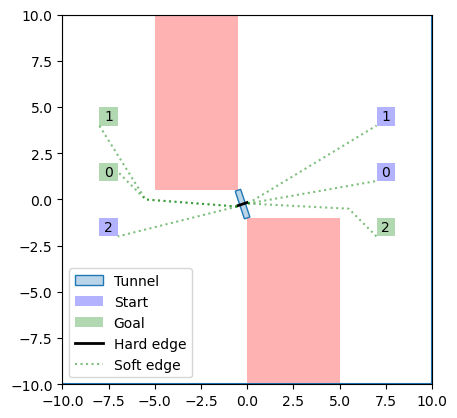

In [113]:
ax = plt.gca()

labeled = False
for tunnel in HG.tunnels:
    plot_polygon(tunnel.region,ax=ax,label='Tunnel' if not labeled else None,add_points =False)
    ent_pts = np.array(tunnel.end_points)
    labeled=True

draw_env(HG.env,ax=ax)

soft_labeled = False
hard_labeled = False
for e in HG.edges:  
    if HG.edges[e]['type'] == 'soft':  
        path = HG.edges[e]['continuous_path']
        ax.plot(path[0,:],path[1,:],alpha = 0.5,color = 'g',ls = 'dotted',label = "Soft edge" if not soft_labeled else None)
        soft_labeled = True
    else:
        u,v = e
        endpoint_locs = np.asarray([HG.nodes[u]['region'].centroid().coords[0],HG.nodes[v]['region'].centroid().coords[0]])
        ax.plot(endpoint_locs[:,0],endpoint_locs[:,1],lw = 2,color = 'black', label = "Hard edge" if not hard_labeled else None)
        hard_labeled = True

   
ax.legend()
plt.show()    



In [101]:
endpoints

array([[-1.34692, -0.61564],
       [ 0.84692,  0.11564]])

In [59]:
HG.start_nodes
    

{2, 3, 4}

In [60]:
HG.goal_nodes
    

{5, 6, 7}

## Step 2: assign locations to nodes in the hybrid graph

In [7]:
import networkx as nx


In [8]:
G.nodes(data=True)

NodeDataView({0: {'type': 'tunnel', 'loc': array([-0.4931 , -0.33103])}, 1: {'type': 'tunnel', 'loc': array([-0.0069 , -0.16897])}, 2: {'type': 'start', 'loc': array([7.5, 1.5]), 'agent': 0}, 3: {'type': 'start', 'loc': array([7.5, 4.5]), 'agent': 1}, 4: {'type': 'start', 'loc': array([-7.5, -1.5]), 'agent': 2}, 5: {'type': 'goal', 'loc': array([-7.5,  1.5]), 'agent': 0}, 6: {'type': 'goal', 'loc': array([-7.5,  4.5]), 'agent': 1}, 7: {'type': 'goal', 'loc': array([ 7.5, -1.5]), 'agent': 2}})

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [11]:
    

# Store G in the hybrid_graph variable.
env.hybrid_graph = G

In [12]:
G.edges(data=True)

EdgeDataView([(0, 1, {'type': 'hard'}), (0, 4, {'type': 'soft'}), (0, 5, {'type': 'soft'}), (0, 6, {'type': 'soft'}), (1, 2, {'type': 'soft'}), (1, 3, {'type': 'soft'}), (1, 7, {'type': 'soft'})])